<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/prophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install the Necessary Library

In [79]:
# Installing the reuired library
!pip install prophet

In [80]:
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# For Facebook Prophet (time series forecasting)
from prophet import Prophet
from prophet.plot import plot_plotly

# Evaluiation
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2: Load and Prepare the Dataset

In [109]:
# Load preprocessed data
df = pd.read_csv('/content/bitcoin_analysis_engineered.csv')

# Display the first few rows of the data
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Coin,Year,Month,...,Quarter,Weekday,Daily_Return,Log_Return,EMA_7,EMA_30,RSI_14,MA_20,Upper_BB,Lower_BB
0,2014-10-06,320.389008,345.134003,302.559998,330.079010,79011800,6.542676e+09,Bitcoin,2014,10,...,4,0,0.029856,0.029419,349.294184,398.996478,30.138935,389.910399,461.027732,318.793066
1,2014-10-07,330.584015,339.247009,320.481995,336.187012,49199900,6.663746e+09,Bitcoin,2014,10,...,4,1,0.018505,0.018336,346.017391,394.944255,17.642549,383.853049,451.334641,316.371457
2,2014-10-08,336.115997,354.364014,327.187988,352.940002,54736300,6.995816e+09,Bitcoin,2014,10,...,4,2,0.049832,0.048630,347.748044,392.234303,27.775351,380.278049,446.265429,314.290669
3,2014-10-09,352.747986,382.726013,347.687012,365.026001,83641104,7.235380e+09,Bitcoin,2014,10,...,4,3,0.034244,0.033671,352.067533,390.478929,35.319233,378.789549,444.741094,312.838004
4,2014-10-10,364.687012,375.066986,352.963013,361.562012,43665700,7.166718e+09,Bitcoin,2014,10,...,4,4,-0.009490,-0.009535,354.441153,388.613321,36.159745,376.422450,441.211135,311.633765


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3779 non-null   object 
 1   Open          3779 non-null   float64
 2   High          3779 non-null   float64
 3   Low           3779 non-null   float64
 4   Close         3779 non-null   float64
 5   Volume        3779 non-null   int64  
 6   Market Cap    3779 non-null   float64
 7   Coin          3779 non-null   object 
 8   Year          3779 non-null   int64  
 9   Month         3779 non-null   int64  
 10  Day           3779 non-null   int64  
 11  Quarter       3779 non-null   int64  
 12  Weekday       3779 non-null   int64  
 13  Daily_Return  3779 non-null   float64
 14  Log_Return    3779 non-null   float64
 15  EMA_7         3779 non-null   float64
 16  EMA_30        3779 non-null   float64
 17  RSI_14        3779 non-null   float64
 18  MA_20         3779 non-null 

### Preprocess the Data

Prophet expects a dataframe with two columns:

- ds: The date column (datetime format).
- y: The target variable (values to forecast).

In [111]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Prepare dataframe for Prophet
df_prophet = df.reset_index()[['Date', 'Close']]
df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [112]:
df_prophet

,ds,y
0,2014-10-06,330.079010
1,2014-10-07,336.187012
2,2014-10-08,352.940002
3,2014-10-09,365.026001
4,2014-10-10,361.562012
...,...,...
3774,2025-02-04,97871.820312
3775,2025-02-05,96615.445312
3776,2025-02-06,96593.296875
3777,2025-02-07,96529.085938


### Train-Test Split


In [85]:
split_date = '2022-12-31'  # Last day of 2022

df_train = df_prophet[df_prophet['ds'] <= split_date]
df_test = df_prophet[df_prophet['ds'] > split_date]

### Train Prophet Model

In [113]:
# Initialize the Prophet model
model = Prophet()

#### training on split data

In [87]:
# Add relevant features as regressors
extra_features = ['Volume', 'EMA_7', 'EMA_30', 'RSI_14', 'MA_20', 'Upper_BB', 'Lower_BB']

for feature in extra_features:
    model.add_regressor(feature)

# Fit model with training data
model.fit(df_train.merge(df[extra_features], left_on='ds', right_index=True))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhznkd0y/t45sm13l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhznkd0y/dchlmt0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13643', 'data', 'file=/tmp/tmprhznkd0y/t45sm13l.json', 'init=/tmp/tmprhznkd0y/dchlmt0g.json', 'output', 'file=/tmp/tmprhznkd0y/prophet_model4qymb4xg/prophet_model-20250212093410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:34:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:34:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### training without splitting

In [114]:
# Define extra features
extra_features = ['Volume', 'EMA_7', 'EMA_30', 'RSI_14', 'MA_20', 'Upper_BB', 'Lower_BB']

# Add relevant features as regressors
for feature in extra_features:
    model.add_regressor(feature)

# Merge extra features into the full dataset before training
df_merged = df_prophet.merge(df[extra_features], left_on='ds', right_index=True, how='left')

# Fit the model on the full dataset (not just df_train)
model.fit(df_merged)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhznkd0y/vbvj7a1c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhznkd0y/qhvhpvcw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82244', 'data', 'file=/tmp/tmprhznkd0y/vbvj7a1c.json', 'init=/tmp/tmprhznkd0y/qhvhpvcw.json', 'output', 'file=/tmp/tmprhznkd0y/prophet_modelj9zq8sb8/prophet_model-20250212100052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:00:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:00:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Predictions on Test Data

In [88]:
future = model.make_future_dataframe(periods=len(df_test), freq='D')

# Merge extra features for test period
future = future.merge(df[extra_features], left_on='ds', right_index=True, how='left')

# Predict future values
forecast = model.predict(future)

In [89]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3774,2025-02-04,97590.341578,96622.208159,98603.296405
3775,2025-02-05,96701.301336,95591.425006,97757.414694
3776,2025-02-06,95890.815134,94888.637167,96901.746710
3777,2025-02-07,95156.815190,94074.125181,96193.066466
3778,2025-02-08,94669.967843,93646.693238,95691.283401


The forecast dataframe includes:

- ds: The date.
- yhat: The predicted value.
- yhat_lower and yhat_upper: The lower and upper bounds of the prediction interval.

### Future predictions

In [118]:
from pandas.tseries.offsets import Day

# Define the start date for future predictions
start_date = '2025-02-08'
end_date = pd.to_datetime(start_date) + pd.DateOffset(days=365)

# Generate future dataframe with specific date range
prediction_dates = pd.date_range(start=start_date, end=end_date, freq='D')
prediction = pd.DataFrame({'ds': prediction_dates})

# Merge extra features for test period
prediction = prediction.merge(df[extra_features], left_on='ds', right_index=True, how='left')

# Fill missing feature values using forward fill (updated method)
prediction[extra_features] = prediction[extra_features].ffill()

# Predict future values
forecast = model.predict(prediction)

# Display last few rows to check if predictions start from 2025-02-08
print(forecast[['ds', 'yhat']].head(10))

          ds          yhat
0 2025-02-08  96070.119893
1 2025-02-09  96053.927356
2 2025-02-10  96110.852776
3 2025-02-11  96054.526553
4 2025-02-12  96089.103329
5 2025-02-13  96016.986619
6 2025-02-14  96036.292866
7 2025-02-15  95991.978368
8 2025-02-16  95974.084957
9 2025-02-17  96031.427176


In [127]:
# Save forecast to a CSV file
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("predictions.csv", index=False)

print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


### Evaluate Model Performance on Test Data

In [90]:
# Extract actual vs predicted values
df_test_forecast = forecast.set_index('ds').loc[df_test['ds']]['yhat']

# Compute metrics
mae = mean_absolute_error(df_test['y'], df_test_forecast)
mse = mean_squared_error(df_test['y'], df_test_forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 1014.5892282576214
MSE: 2258108.4986540414
RMSE: 1502.7004021607372


### Visualize predictions

### Basic Prophet Forecast Plot


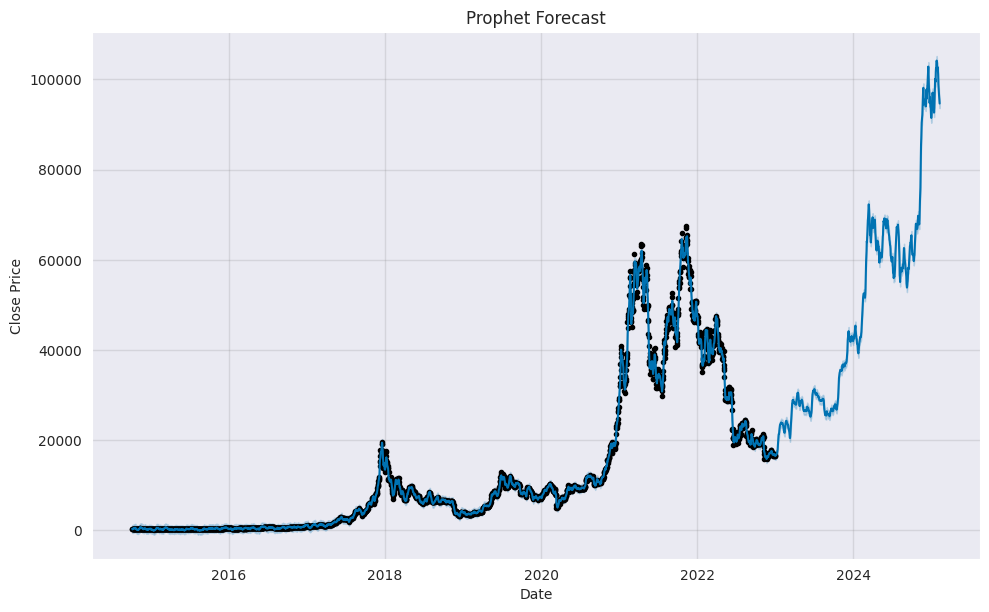

In [91]:
# Plot the forecast
model.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

### Compare Predictions vs Actual

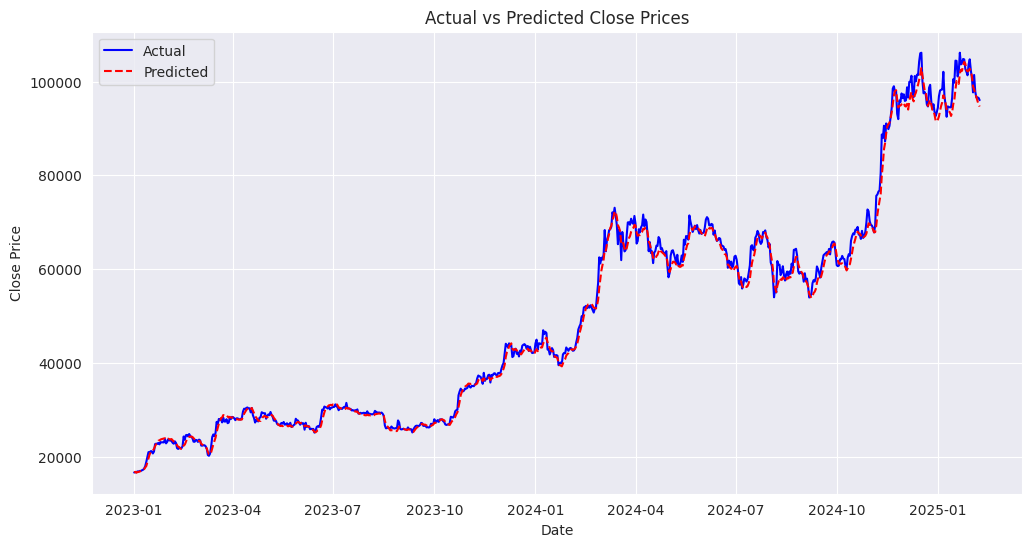

In [92]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_test['ds'], df_test['y'], label="Actual", color='blue')

# Plot predicted values
plt.plot(df_test['ds'], df_test_forecast, label="Predicted", color='red', linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.show()

### Components of Prophet Model

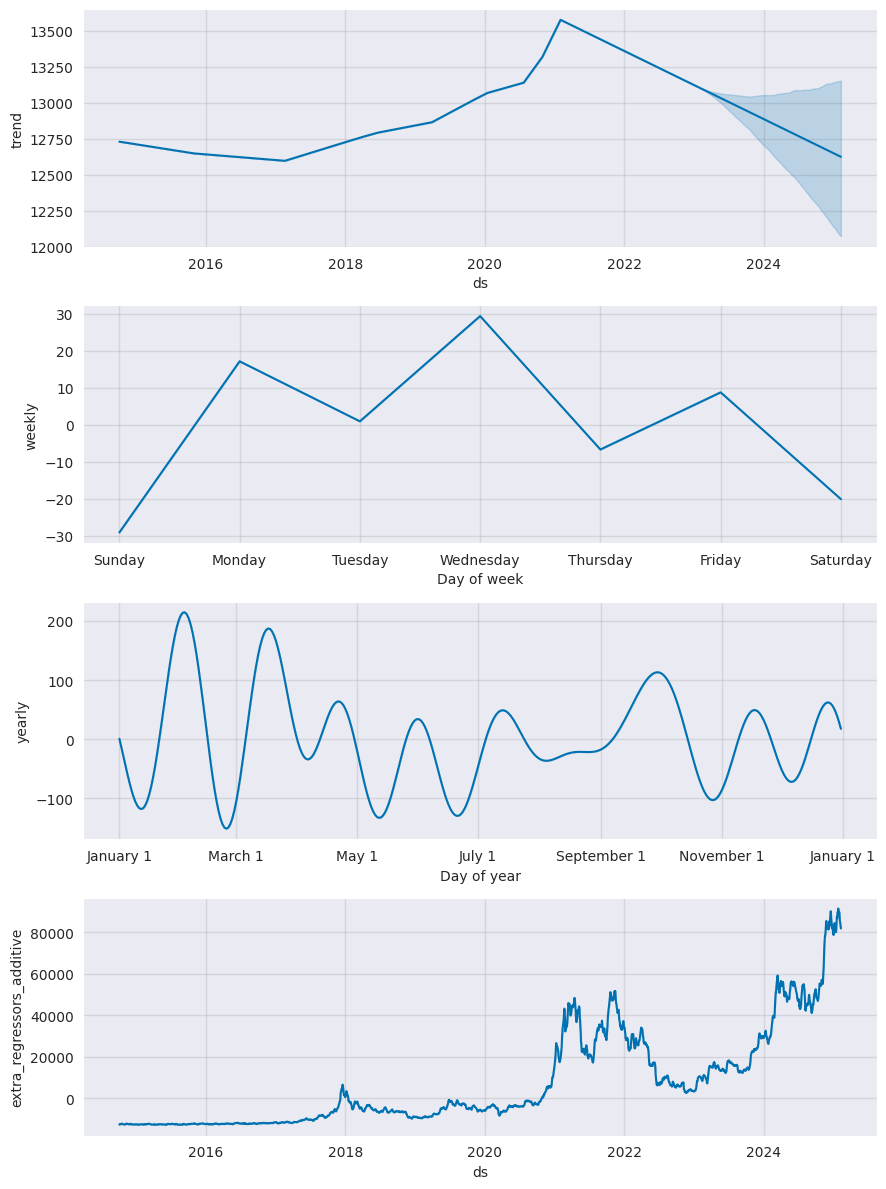

In [93]:
model.plot_components(forecast)
plt.show()

## 7. Diagnostics

In [122]:
df_cv = cross_validation(model, horizon = '365 days')

INFO:prophet:Making 13 forecasts with cutoffs between 2018-02-10 00:00:00 and 2024-02-09 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmprhznkd0y/hy1q_p1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhznkd0y/hozegd0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52342', 'data', 'file=/tmp/tmprhznkd0y/hy1q_p1t.json', 'init=/tmp/tmprhznkd0y/hozegd0w.json', 'output', 'file=/tmp/tmprhznkd0y/prophet_modelv10yty6f/prophet_model-20250212101208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:12:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:12:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhznkd0y/dxnxijxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhznkd0y/stdt4v3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [123]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
4740,2025-02-04,98861.909292,97982.710191,99741.644062,97871.820312,2024-02-09
4741,2025-02-05,97894.090215,97063.616899,98778.611478,96615.445312,2024-02-09
4742,2025-02-06,97055.532889,96157.191585,97885.056709,96593.296875,2024-02-09
4743,2025-02-07,96355.376403,95474.321286,97177.254060,96529.085938,2024-02-09
4744,2025-02-08,95817.042783,94971.999285,96740.602589,96026.765625,2024-02-09


In [124]:
df_performance = performance_metrics(df_cv)

In [125]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,1.152404e+06,1073.500752,645.350956,0.026662,0.019328,0.026362,0.649789
1,37 days 00:00:00,1.169971e+06,1081.652030,652.395154,0.026704,0.019328,0.026406,0.646474
2,37 days 12:00:00,1.163693e+06,1078.746022,646.859129,0.026562,0.018780,0.026266,0.651899
3,38 days 00:00:00,1.173153e+06,1083.121660,652.274549,0.026751,0.018967,0.026474,0.646172
4,38 days 12:00:00,1.165321e+06,1079.500524,648.296981,0.026579,0.018666,0.026300,0.647679
...,...,...,...,...,...,...,...,...
653,363 days 00:00:00,1.701764e+06,1304.516776,943.786799,0.058807,0.024298,0.053338,0.449066
654,363 days 12:00:00,1.731031e+06,1315.686489,944.121249,0.058101,0.024269,0.052750,0.451477
655,364 days 00:00:00,1.789835e+06,1337.847322,958.633593,0.059084,0.024408,0.053631,0.446655
656,364 days 12:00:00,1.772151e+06,1331.221459,950.596293,0.058207,0.024298,0.052869,0.451477


In [126]:
print(f"MAE: {df_performance['mae'].values[0]}")
print(f"MSE: {df_performance['mse'].values[0]}")
print(f"RMSE: {df_performance['rmse'].values[0]}")

MAE: 645.3509563615447
MSE: 1152403.8639973213
RMSE: 1073.5007517451124
